# Fase 3: Análisis Integral de Resultados (Consolidado)

Este notebook unifica todos los análisis de la Fase 3, utilizando los datos generados por el pipeline CLI.

### Contenido:
1. **Estructura Global**: Matriz de Similitud entre todas las ventanas temporales.
2. **Dinámica de Complejidad**: Evolución de la dimensionalidad intrínseca (k).
3. **Deriva Semántica**: Estabilidad del subespacio y desplazamiento del centroide.
4. **Proyecciones Híbridas (Granular)**: Análisis detallado de significado frente a anclajes ortogonalizados (Lowdin).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = '../data'
results_path = os.path.join(DATA_DIR, 'phase3_results.parquet')
sim_matrix_path = os.path.join(DATA_DIR, 'phase3_sim_matrix.csv')

if os.path.exists(results_path):
    df = pd.read_parquet(results_path)
    print(f"Resultados cargados: {len(df)} ventanas.")
else:
    print("ERROR: Resultados principales no encontrados.")

if os.path.exists(sim_matrix_path):
    sim_df = pd.read_csv(sim_matrix_path, index_col=0)
    print(f"Matriz de Similitud cargada: {sim_df.shape}")
else:
    print("WARNING: Matriz de similitud no encontrada.")

Resultados cargados: 21 ventanas.
Matriz de Similitud cargada: (21, 21)


## 1. Estructura Global (Matriz de Similitud)
Visualización de la coherencia global del discurso. Bloques diagonales indican periodos estables.

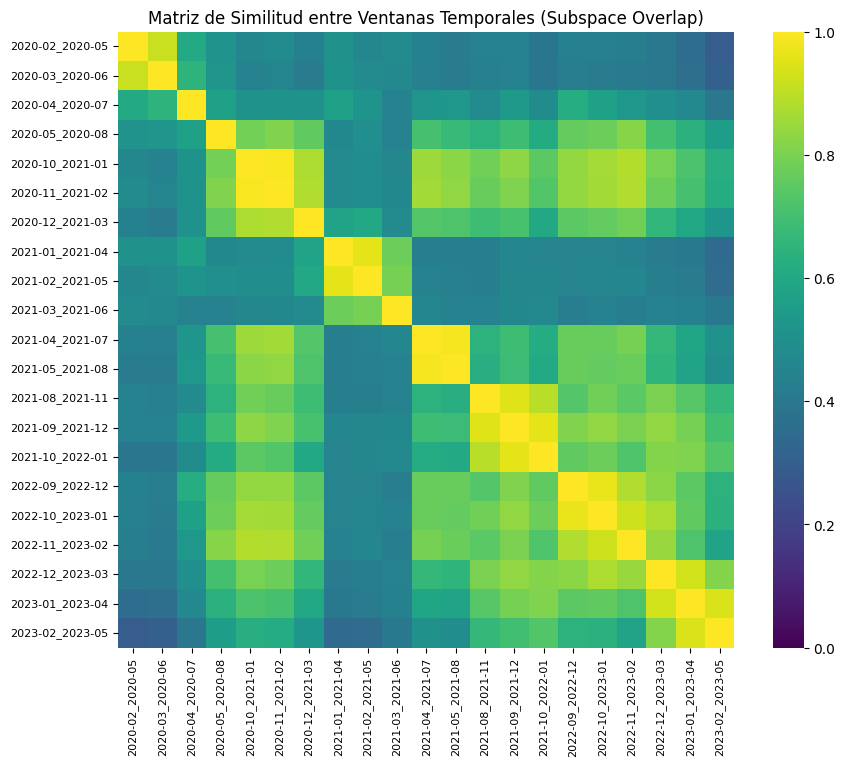

In [2]:
if 'sim_df' in locals():
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_df, cmap='viridis', square=True, vmin=0, vmax=1)
    plt.title("Matriz de Similitud entre Ventanas Temporales (Subspace Overlap)")
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.show()

## 2. Dinámica de Complejidad y Estabilidad
¿Cómo cambia la riqueza del discurso (K) y cuánto cambia el tema (Drift)?

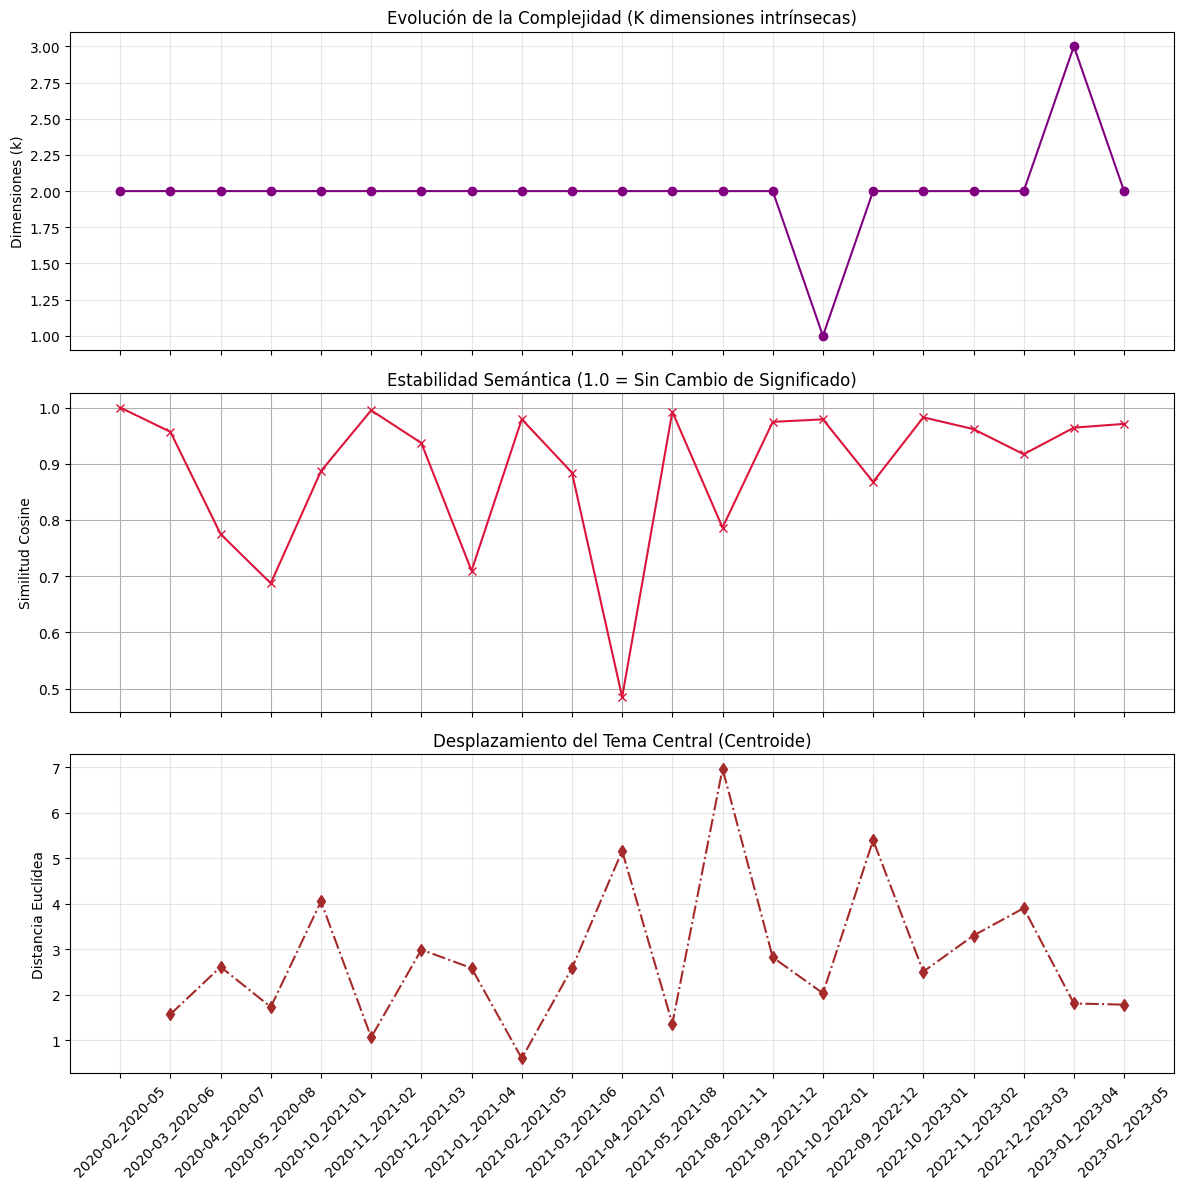

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# K Evolution
if 'intrinsic_dimension_k' in df.columns:
    axes[0].plot(df['date'], df['intrinsic_dimension_k'], marker='o', color='purple', linestyle='-')
    axes[0].set_title("Evolución de la Complejidad (K dimensiones intrínsecas)")
    axes[0].set_ylabel("Dimensiones (k)")
    axes[0].grid(True, alpha=0.3)

# Subspace Drift
axes[1].plot(df['date'], df['similarity'], marker='x', color='crimson', label='Estabilidad (Subespacio)')
axes[1].set_title("Estabilidad Semántica (1.0 = Sin Cambio de Significado)")
axes[1].set_ylabel("Similitud Cosine")
axes[1].grid(True)

# Centroid Drift
if 'centroid_drift' in df.columns:
    axes[2].plot(df['date'], df['centroid_drift'], marker='d', color='brown', linestyle='-.')
    axes[2].set_title("Desplazamiento del Tema Central (Centroide)")
    axes[2].set_ylabel("Distancia Euclídea")
    axes[2].grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Proyecciones Ortogonales (Análisis Confirmatorio Híbrido)
Proyección sobre anclajes ortogonalizados (Löwdin).
**Filas**: Dimensiones de Yape (Centroide, Dim 1, Dim 2).
**Marcadores**: Sólido (Contextual) vs Punteado (Estático).

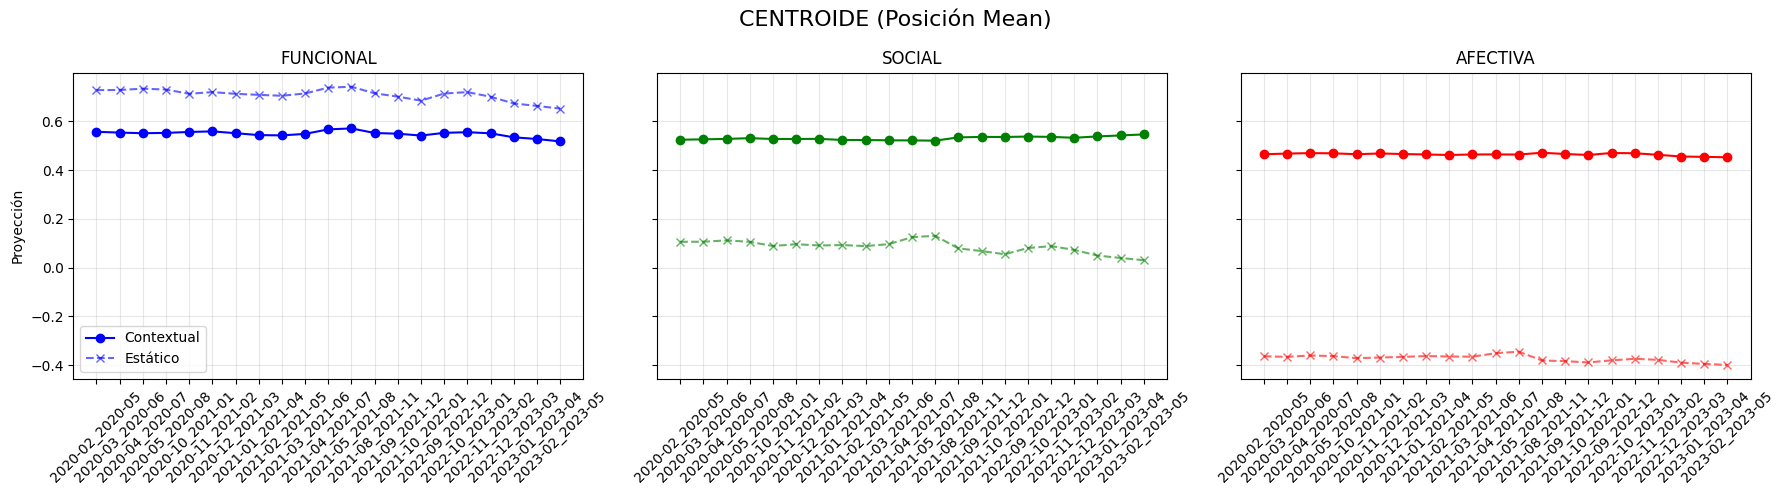

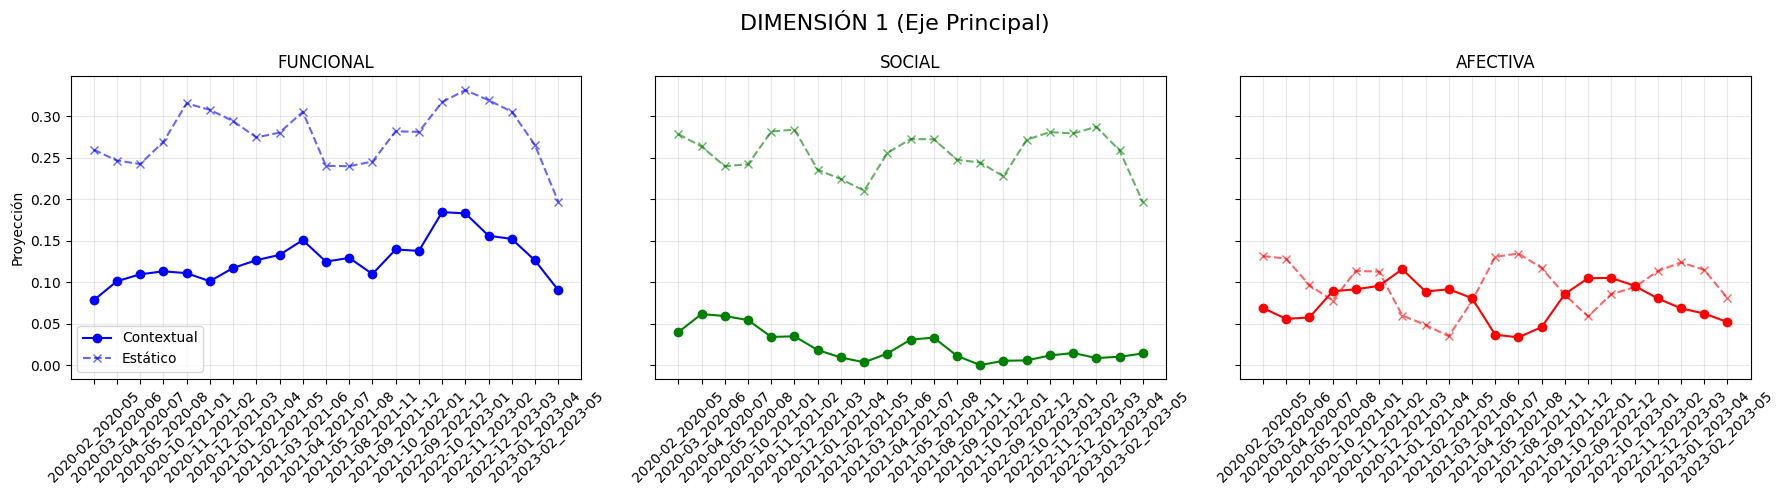

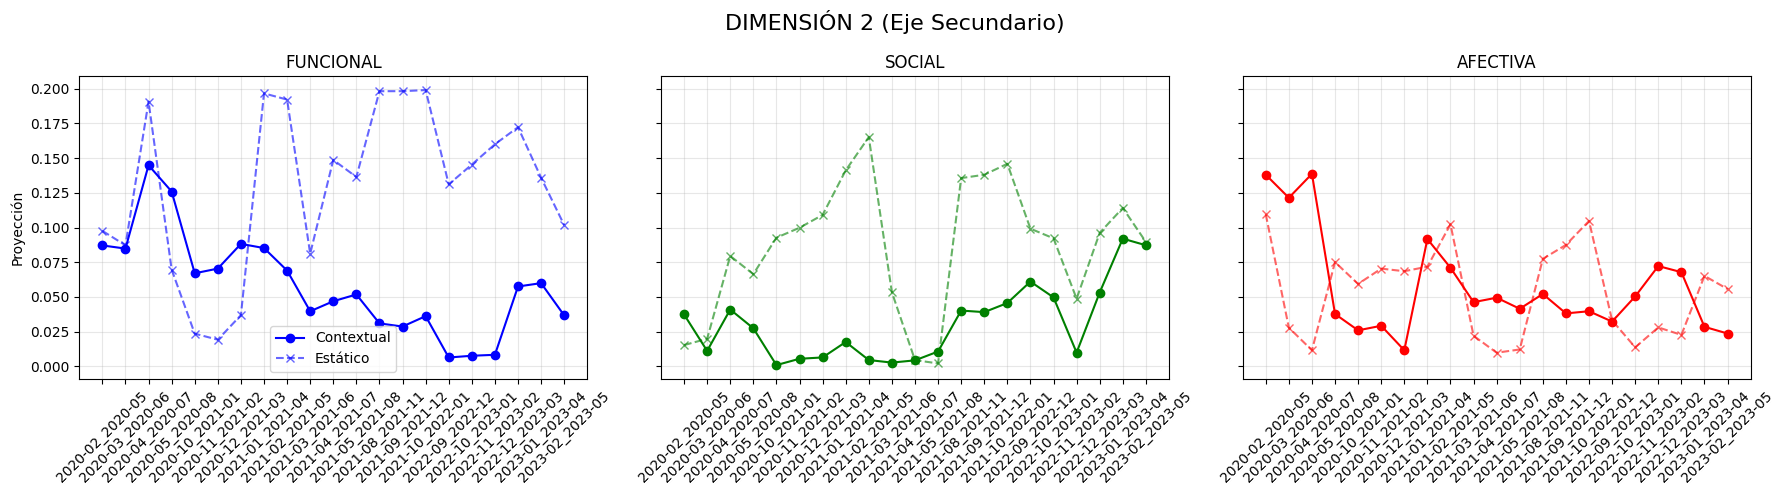

In [4]:
def plot_projection_row(df, metric_prefix, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
    
    dims = {
        'funcional': {'color': 'blue', 'ax': axes[0]},
        'social': {'color': 'green', 'ax': axes[1]},
        'afectiva': {'color': 'red', 'ax': axes[2]}
    }
    
    found_data = False
    
    for dim_name, props in dims.items():
        ax = props['ax']
        color = props['color']
        
        col_ctx = f'{metric_prefix}{dim_name}_contextual'
        if col_ctx in df.columns:
            found_data = True
            ax.plot(df['date'], df[col_ctx], 
                    color=color, linestyle='-', marker='o', label='Contextual')
        
        col_sta = f'{metric_prefix}{dim_name}_static'
        if col_sta in df.columns:
            found_data = True
            ax.plot(df['date'], df[col_sta], 
                    color=color, linestyle='--', marker='x', alpha=0.6, label='Estático')
            
        ax.set_title(f"{dim_name.upper()}")
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        if dim_name == 'funcional':
            ax.set_ylabel("Proyección")
            ax.legend()

    if found_data:
        plt.suptitle(f"{title_prefix}", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        plt.close() # Don't show empty figure

plot_projection_row(df, 'score_centroid_', 'CENTROIDE (Posición Mean)')
plot_projection_row(df, 'score_dim1_', 'DIMENSIÓN 1 (Eje Principal)')
plot_projection_row(df, 'score_dim2_', 'DIMENSIÓN 2 (Eje Secundario)')